In [24]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from functools import partial

In [25]:
# constants
NUM_OF_ARMS = 10
NUM_OF_STEPS = 1000
NUM_OF_RUNS = 2000

In [26]:
# environment implementation
class KArmedBandit:

    def __init__(self):
        self.reward = np.random.randn(NUM_OF_ARMS)
        self.optimal_choice = np.argmax(self.reward)

    def step(self, action):
        return self.reward[action] + np.random.randn()

In [27]:
# agent implementation
class GreedyAgent:

    def __init__(self, epsilon=0, initial=0, alpha=0.1):
        self.q_estimation = np.zeros(NUM_OF_ARMS) + initial
        self.epsilon = epsilon
        self.alpha = alpha
    
    def act(self):
        if np.random.rand() < self.epsilon: action = np.random.choice(np.arange(NUM_OF_ARMS))
        else: action = np.argmax(self.q_estimation)
        return action
    
    def learn(self, action, reward):
        self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])

In [30]:
# run tests
def run(agents):
    rewards = np.zeros((len(agents), NUM_OF_STEPS))
    optimal = np.zeros((len(agents), NUM_OF_STEPS))
    for i, agent in enumerate(agents):
        env = KArmedBandit()
        for step in np.arange(NUM_OF_STEPS):
            action = agent.act()
            reward = env.step(action)
            agent.learn(action, reward)
            rewards[i, step] = reward
            optimal[i, step] = (action == env.optimal_choice)
    return rewards, optimal

In [31]:
# generate results 
agents = [GreedyAgent(epsilon=0.1), GreedyAgent(initial=5)]
results = Parallel(n_jobs=6)(delayed(partial(run, agents))() for _ in range(NUM_OF_RUNS))
rewards = np.asarray([result[0] for result in results]) 
optimal = np.asarray([result[1] for result in results])

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/x_/dfv90_3n7hg5f9vmpct87lf00000gn/T/ipykernel_80192/2941658791.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(avg_optimal[0], label=f'$\epsilon$-greedy')


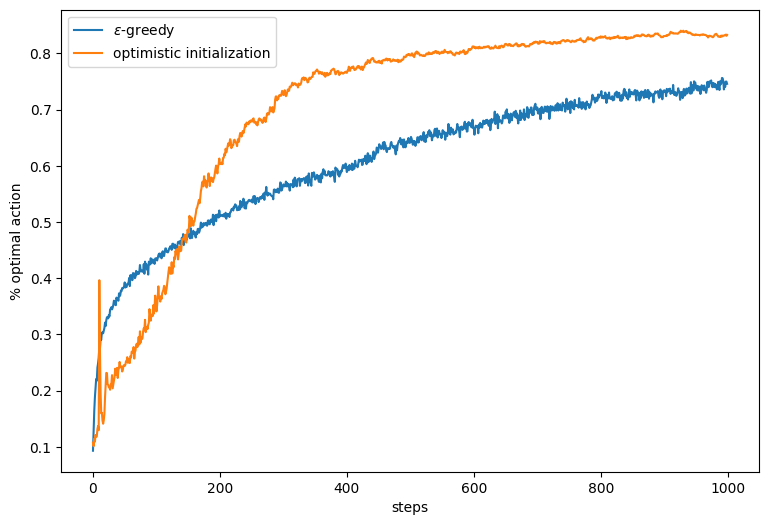

In [33]:
# generate figure 2.3
avg_rewards = np.mean(rewards, axis=0)
avg_optimal = np.mean(optimal, axis=0)

plt.figure(figsize=(9, 6))

plt.plot(avg_optimal[0], label='e-greedy')
plt.plot(avg_optimal[1], label='optimistic initialization')

plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()